# Quick intro to data analysis with pandas and seaborn

Ben Shanks: <shanksbe@ornl.gov>

You can find this Jupyter notebook and the raw data at <https://github.com/benshanks/pandas_example>

#### Documentation

* Pandas: python-based data analysis package (<https://pandas.pydata.org/>)
    * quickstart: <https://pandas.pydata.org/pandas-docs/stable/10min.html>
* Seaborn: data visualization package that plays nice with pandas (<https://seaborn.pydata.org/>)

## Setup

First we import the packages we'll be using and set style.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt #package for plotting in python
import numpy as np #package for scientific computing in python 

sns.set(style="darkgrid", context="talk") #sets plot style: dark background, white grid lines, big labels

## Loading and Viewing pandas data

I've saved some MJD calibration data in a hdf5 file.  We can load an hdf file into a "dataframe," the tabular data structure used in pandas.  Let's take a peek at the data we have stored inside:

In [2]:
df =  pd.read_hdf("example_data.h5", key="data")
print( df.head() )

   channel  current_max_5  timestamp  runNumber        ecal
0      600       0.233672   54480169      11510   -0.656751
1      600       0.352912   54898077      11510   -0.703234
2      600       0.245731   55963514      11510   -0.529784
3      600      17.215980   56380657      11510  156.283296
4      600       0.231651   56786458      11510   -0.784975


Pandas also includes some simple commands to manipulate and examine the data.

#### Cutting

Cuts can be made on the data using boolean masks, much like in ROOT

In [3]:
dep = df.loc[(df.ecal > 1585)&(df.ecal < 1597)]
print("We have {} DEP-region events".format(len(dep)))

We have 1631 DEP-region events


#### Grouping

We can use the groupby method to split the data based on one element.  Then, we can apply a function to each group.  For example, we might want to count the number of events for each channel.

In [4]:
#i only use the timestamp column because the count is the same for each unless there are NaNs
df.groupby("channel").timestamp.count()
#if we wanted it split by channel and run number we could do
#df.groupby(["channel", "runNumber").timestamp.count()

channel
600    270194
626    527015
Name: timestamp, dtype: int64

For more information, see <https://pandas.pydata.org/pandas-docs/stable/groupby.html>.  This is a very common operation in pandas -- you can apply any custom function to groups of data this way.

#### Unique elements

With some data, it's nice to quickly see a list of unique elements in your dataframe

In [5]:
unique_chans = df.channel.unique()
print("Unique channels: " + ', '.join(str(chan) for chan in unique_chans)   )

Unique channels: 600, 626


## Energy Spectra

Let's start by taking a look by plotting some energy spectra for each channel.  Seaborn makes it easy to split data across a category using the FacetGrid class -- if you're going to use pandas, you should really also take a look at Seaborn.  Here, I plot all channels in one figure, giving each channel a unique color

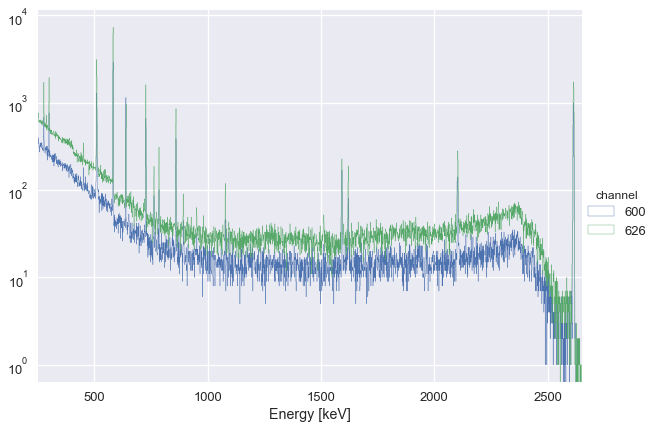

In [6]:
bins = np.arange(250, 2650, 1) #1 keV bins from [250,2650)

g = sns.FacetGrid(df, hue="channel", size=6, aspect=1.4)

#Perform the matplotlib plt.hist function on the "ecal" data column for each channel
#(and make a legend while we're at it)
g.map(plt.hist, "ecal", bins=bins, histtype="step").add_legend()
g.set(yscale="log", xlabel="Energy [keV]", xlim=(250,2650))
plt.show()

We can also split the grid into multiple plots, with each channel on its own axis

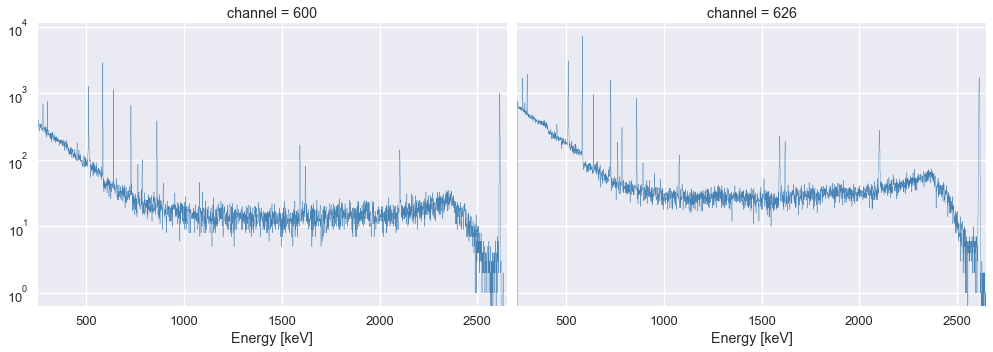

In [7]:
g = sns.FacetGrid(df, col="channel", margin_titles=True, size=5, aspect=1.4)

g.map(plt.hist, "ecal", color="steelblue", bins=bins, histtype="step")
g.set(yscale="log", xlabel="Energy [keV]", xlim=(250,2650))
plt.show()

If you feel really strongly about not using Seaborn, you can of course do the same thing by making your own loop.

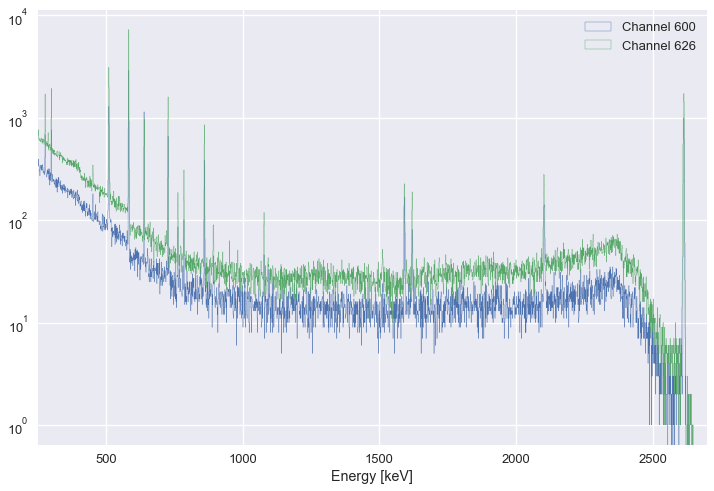

In [8]:
plt.figure(figsize=(12,8))
for chan, df_chan in df.groupby("channel"):
    #Pandas dataframes have a "hist" method, which is a wrapper of the matplotlib hist function
    df_chan["ecal"].hist(bins=bins, histtype="step", label="Channel {}".format(chan))
plt.xlabel("Energy [keV]")
plt.gca().set_xlim(250,2700)
plt.yscale("log")
plt.legend()
plt.show()
    

# A/E Plots

First we add a new column to the dataframe for the A/E value

In [9]:
df["a/e"] = df["current_max_5"]/df["ecal"]

Let's say we only want to look at one channel now.  We can go ahead and cut on that channel:

In [10]:
df_chan = df.loc[(df.channel == 600)&(df.ecal>1000)&(df.ecal<2700)]

### A/E vs Energy

We can plot a 2D histogram of A/E vs Energy.  Rather than use Seaborn, let's just use the matplotlib histogram functionality.

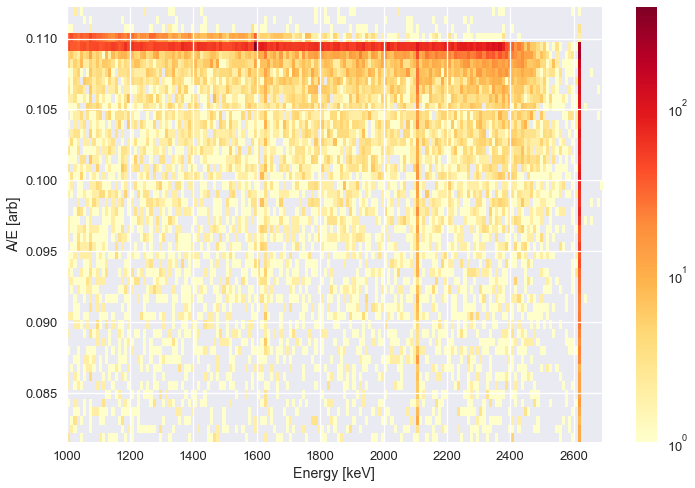

In [11]:
from matplotlib.colors import LogNorm #so that we can plot colors on a logscale

#create a new figure for the plot
plt.figure(figsize=(12,8))

#set bins edges for energy and a/e
e_bins = np.arange(1000,2700,10) #[1000,2700) with step size of 10
ae_min, ae_max = df_chan["a/e"].quantile([0.05, 0.98]) #gets percentiles of data
ae_bins = np.linspace(ae_min,ae_max,51) # min to max value with 51 total points (ie, 50 bins)


h,x,y,i=plt.hist2d(df_chan.ecal, df_chan["a/e"], #you can address a single column either with df.name or df["name"]
                   bins=[e_bins, ae_bins],
                   norm=LogNorm(),
                   cmap="YlOrRd") #colormap 
plt.xlabel("Energy [keV]")
plt.ylabel("A/E [arb]")
plt.colorbar() #show the colorscale on the figure
plt.show()

### A/E at the DEP

With a simple energy cut, we can make a histogram of A/E in the double escape peak region

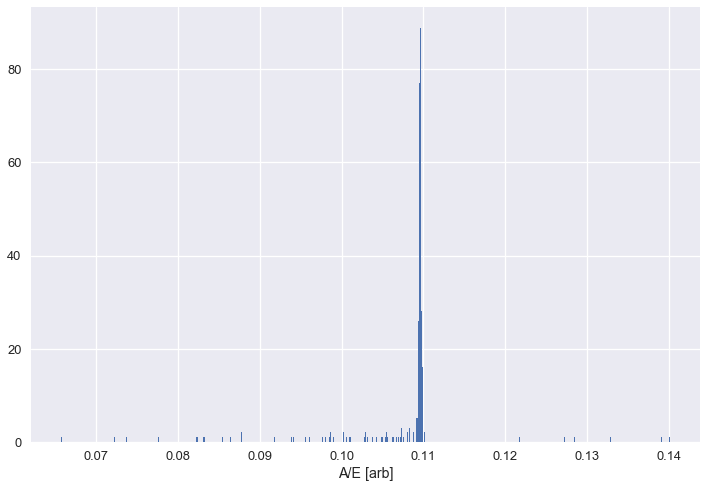

In [12]:
dep_cut = (df_chan.ecal < 1599)&(df_chan.ecal>1585)

plt.figure(figsize=(12,8))
df_chan.loc[dep_cut, "a/e"].hist(bins="auto")
# plt.yscale("log")
plt.xlabel("A/E [arb]")
plt.show()

If we want to "zoom in" on the peak...

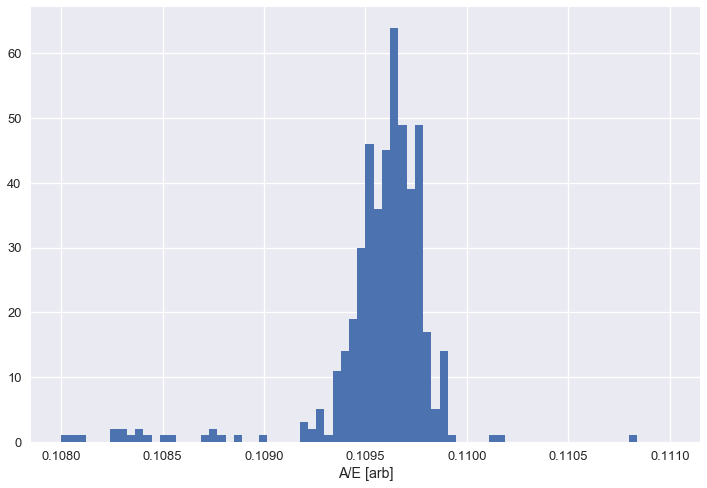

In [13]:
plt.figure(figsize=(12,8))
df_chan.loc[dep_cut, "a/e"].hist(bins=np.linspace(0.108, 0.111, 75))
# plt.yscale("log")
plt.xlabel("A/E [arb]")
plt.show()